In [2]:
#importing necessary libraries
import pandas as pd
import numpy as np
import json

# plotting
import matplotlib.pyplot as plt

#opening data
import os
import pathlib
import warnings

#used for plots
from mplsoccer import Pitch
from scipy.stats import binned_statistic_2d

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

In [3]:
df = pd.DataFrame()
file_name = 'events_England.json'
path = os.path.join(str(pathlib.Path().resolve().parents[0]), 'data', 'Wyscout', 'events', file_name)
with open(path) as f:
    data = json.load(f)
df = pd.concat([df, pd.DataFrame(data)])

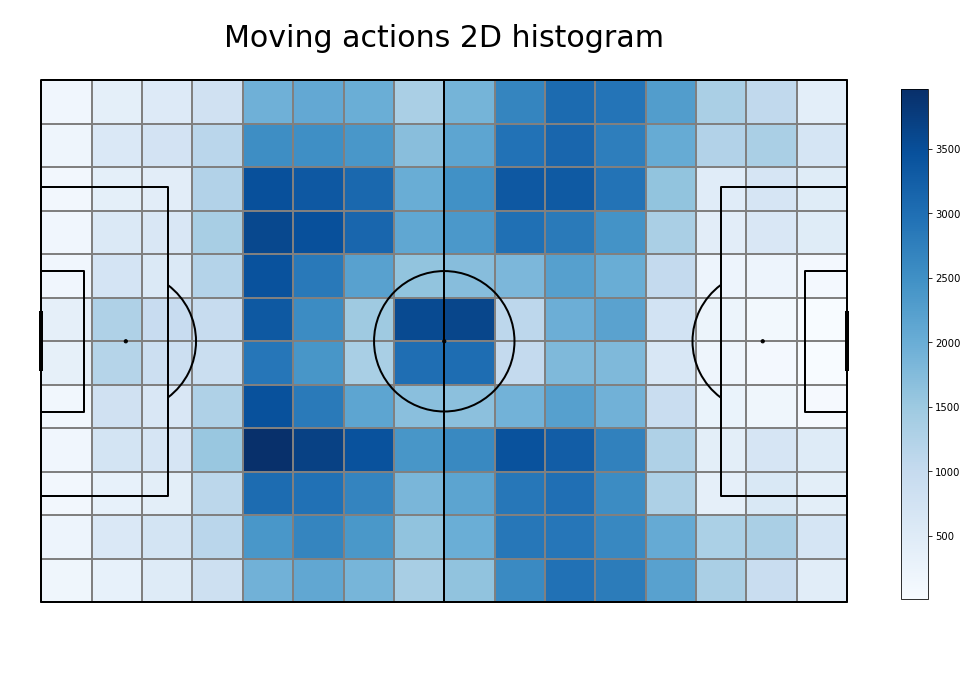

In [4]:
next_event = df.shift(-1, fill_value=0)
df["nextEvent"] = next_event["subEventName"]
df["kickedOut"] = df.apply(lambda x: 1 if x.nextEvent == "Ball out of the field" else 0, axis = 1)

#get move_df
move_df = df.loc[df['subEventName'].isin(['Simple pass', 'High pass', 'Head pass', 'Smart pass', 'Cross'])]
#filtering out of the field
delete_passes = move_df.loc[move_df["kickedOut"] == 1]
move_df = move_df.drop(delete_passes.index)

#extract coordinates
move_df["x"] = move_df.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
move_df["y"] = move_df.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)
move_df["end_x"] = move_df.positions.apply(lambda cell: (cell[1]['x']) * 105/100)
move_df["end_y"] = move_df.positions.apply(lambda cell: (100 - cell[1]['y']) * 68/100)

#create 2D histogram of these
pitch = Pitch(line_color='black',pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
move = pitch.bin_statistic(move_df.x, move_df.y, statistic='count', bins=(16, 12), normalize=False)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Moving actions 2D histogram', fontsize = 30)
plt.show()
#get the array
move_count = move["statistic"]

In [5]:
df.head(3)

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,nextEvent,kickedOut
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,High pass,0
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,Head pass,0
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,Head pass,0


In [6]:
move_df.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,nextEvent,kickedOut,x,y,end_x,end_y
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,High pass,0,51.45,34.68,32.55,14.96
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,Head pass,0,32.55,14.96,53.55,17.00
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,Head pass,0,53.55,17.00,36.75,19.72
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174,Simple pass,0,36.75,19.72,43.05,3.40
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175,Simple pass,0,43.05,3.40,75.60,8.16


In [7]:
move_count

array([[ 155.,  396.,  522.,  800., 1953., 2084., 2001., 1345., 1888.,
        2667., 3059., 2921., 2284., 1341., 1066.,  401.],
       [ 204.,  598.,  750., 1149., 2542., 2523., 2400., 1709., 2156.,
        2955., 3132., 2786., 2041., 1257., 1347.,  695.],
       [ 128.,  385.,  442., 1255., 3473., 3354., 3107., 2017., 2487.,
        3355., 3314., 2936., 1613.,  470.,  683.,  487.],
       [ 166.,  573.,  618., 1379., 3596., 3480., 3131., 2117., 2370.,
        2981., 2836., 2460., 1342.,  432.,  627.,  480.],
       [ 159.,  717.,  574., 1220., 3444., 2860., 2206., 1607., 1711.,
        1829., 2236., 2014., 1030.,  226.,  224.,   97.],
       [ 371., 1285.,  963.,  974., 3331., 2568., 1479., 3564., 3632.,
        1108., 1986., 2193.,  765.,  239.,  106.,   18.],
       [ 356., 1205.,  880.,  907., 2884., 2412., 1369., 3014., 3021.,
        1019., 1794., 1791.,  633.,  197.,   95.,   12.],
       [ 137.,  799.,  615., 1282., 3453., 2840., 2150., 1685., 1665.,
        1910., 2242., 1937

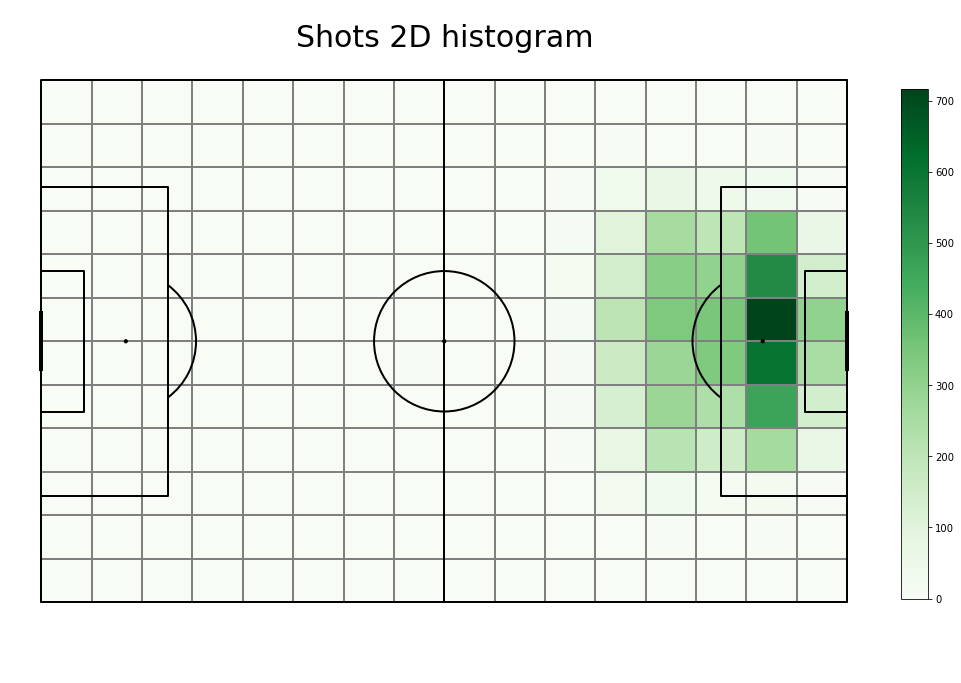

In [8]:
#get shot df
shot_df = df.loc[df['subEventName'] == "Shot"]
shot_df["x"] = shot_df.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
shot_df["y"] = shot_df.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)

#create 2D histogram of these
shot = pitch.bin_statistic(shot_df.x, shot_df.y, statistic='count', bins=(16, 12), normalize=False)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(shot, cmap='Greens', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shots 2D histogram', fontsize = 30)
plt.show()

shot_count = shot["statistic"]

In [9]:
shot_count

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          3.,   2.,   2.,   5.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   7.,
         40.,  67.,  43.,  33.,   4.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,  16.,
        105., 256., 204., 359.,  67.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   2.,  17.,
        151., 317., 297., 538., 147.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   2.,   0.,  14.,
        206., 338., 346., 716., 301.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   3.,   1.,   0.,  13.,
        169., 280., 333., 608., 248.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,  15.,
        137., 282., 237., 465., 145.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   5.,
         78., 215., 16

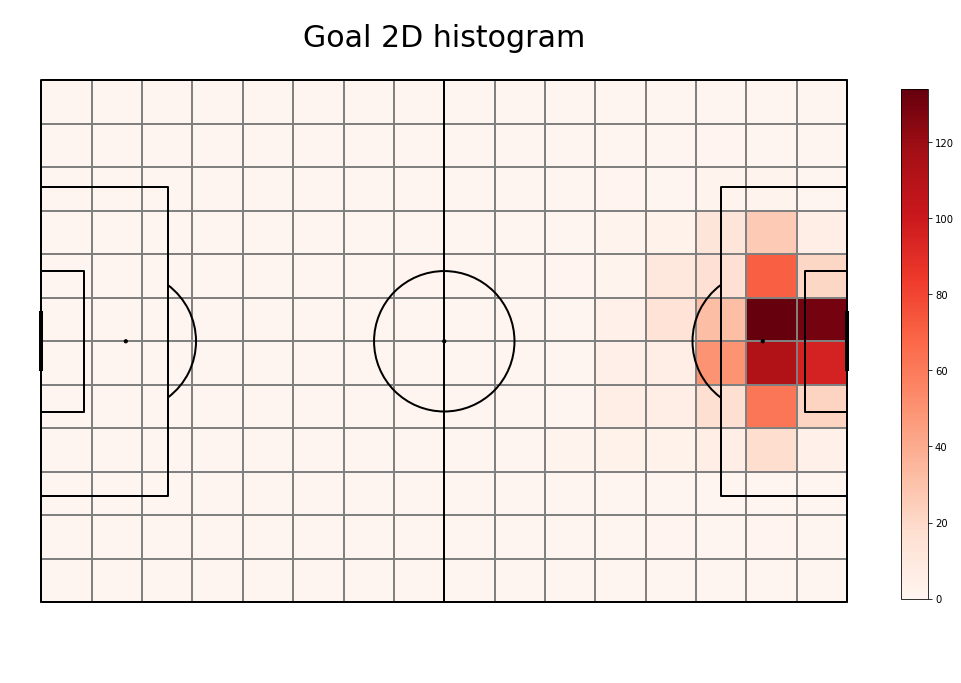

In [10]:
#get goal df
goal_df  = shot_df.loc[shot_df.apply(lambda x: {'id':101} in x.tags, axis = 1)]
goal = pitch.bin_statistic(goal_df.x, goal_df.y, statistic='count', bins=(16, 12), normalize=False)
goal_count = goal["statistic"]

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal 2D histogram', fontsize = 30)
plt.show()

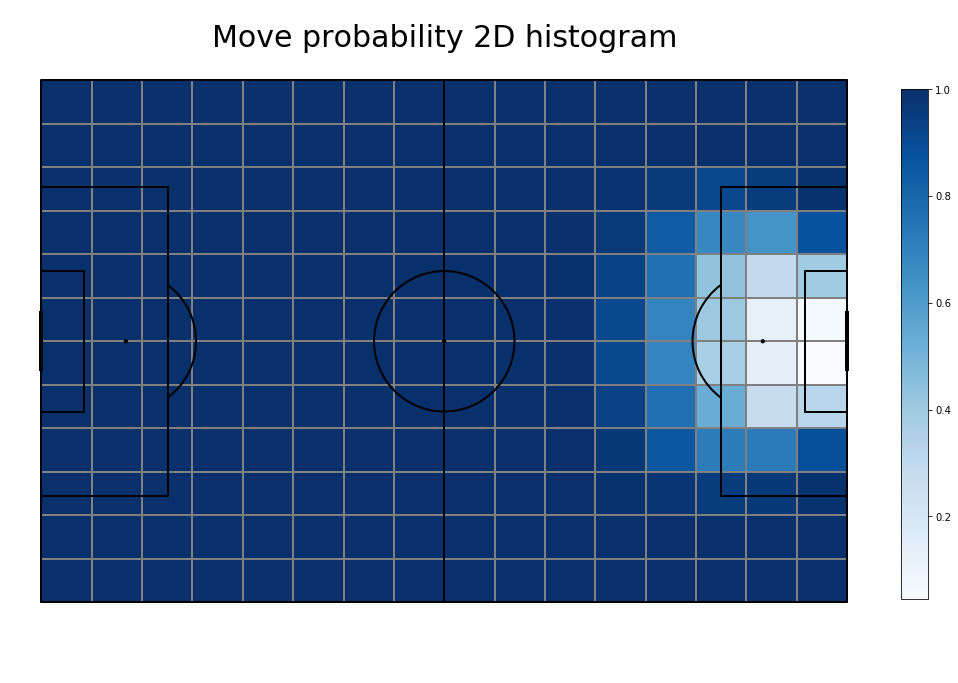

In [11]:
move_probability = move_count/(move_count+shot_count)
#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
move["statistic"] = move_probability
pcm  = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Move probability 2D histogram', fontsize = 30)
plt.show()

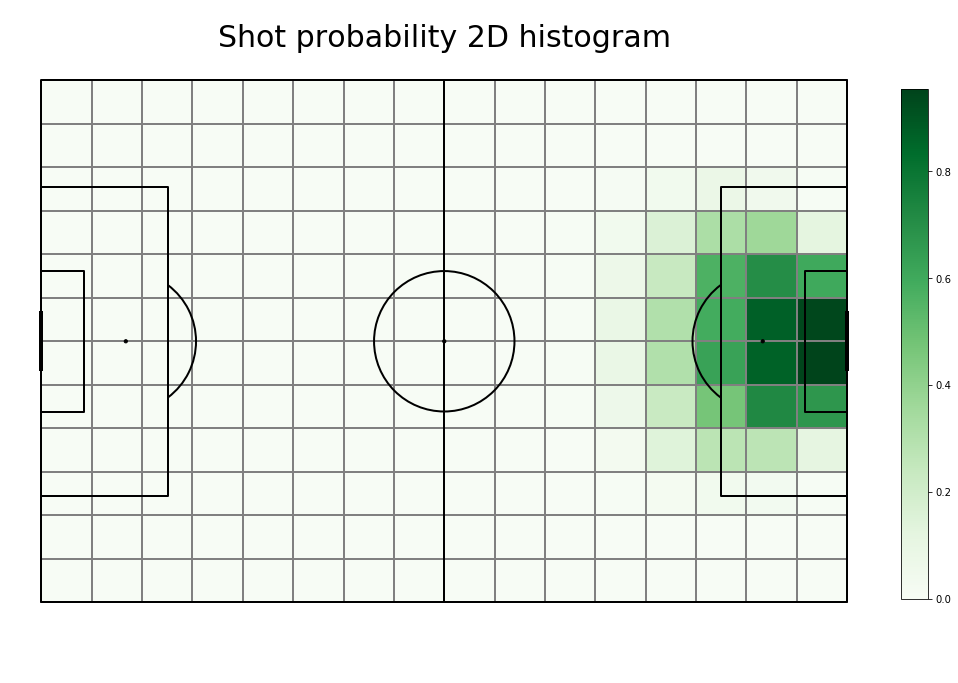

In [12]:
shot_probability = shot_count/(move_count+shot_count)
#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
shot["statistic"] = shot_probability
pcm  = pitch.heatmap(shot, cmap='Greens', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shot probability 2D histogram', fontsize = 30)
plt.show()

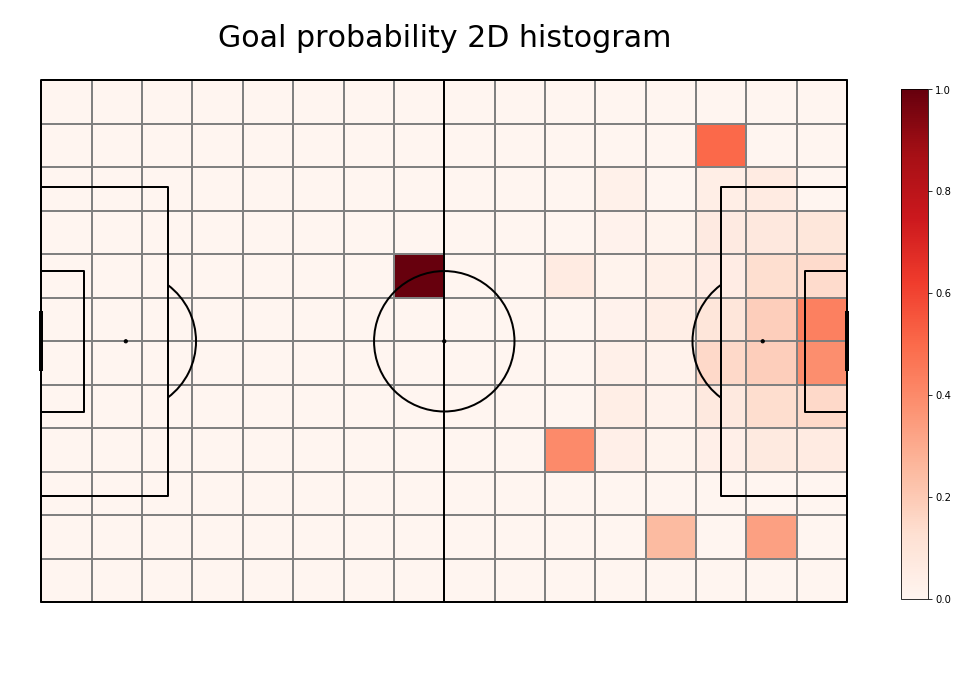

In [13]:
goal_probability = goal_count/shot_count
goal_probability[np.isnan(goal_probability)] = 0
#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
goal["statistic"] = goal_probability
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal probability 2D histogram', fontsize = 30)
plt.show()

In [14]:
#move start index - using the same function as mplsoccer, it should work
move_df["start_sector"] = move_df.apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row.x), np.ravel(row.y),
                                                               values = "None", statistic="count",
                                                               bins=(16, 12), range=[[0, 105], [0, 68]],
                                                               expand_binnumbers=True)[3]]), axis = 1)
#move end index
move_df["end_sector"] = move_df.apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row.end_x), np.ravel(row.end_y),
                                                               values = "None", statistic="count",
                                                               bins=(16, 12), range=[[0, 105], [0, 68]],
                                                               expand_binnumbers=True)[3]]), axis = 1)

#df with summed events from each index
df_count_starts = move_df.groupby(["start_sector"])["eventId"].count().reset_index()
df_count_starts.rename(columns = {'eventId':'count_starts'}, inplace=True)

transition_matrices = []
for i, row in df_count_starts.iterrows():
    start_sector = row['start_sector']
    count_starts = row['count_starts']
    
    #get all events that started in this sector
    this_sector = move_df.loc[move_df["start_sector"] == start_sector]
    df_cound_ends = this_sector.groupby(["end_sector"])["eventId"].count().reset_index()
    df_cound_ends.rename(columns = {'eventId':'count_ends'}, inplace=True)
    
    T_matrix = np.zeros((12, 16))
    for j, row2 in df_cound_ends.iterrows():
        end_sector = row2["end_sector"]
        value = row2["count_ends"]
        T_matrix[end_sector[1] - 1][end_sector[0] - 1] = value
    T_matrix = T_matrix / count_starts
    transition_matrices.append(T_matrix)

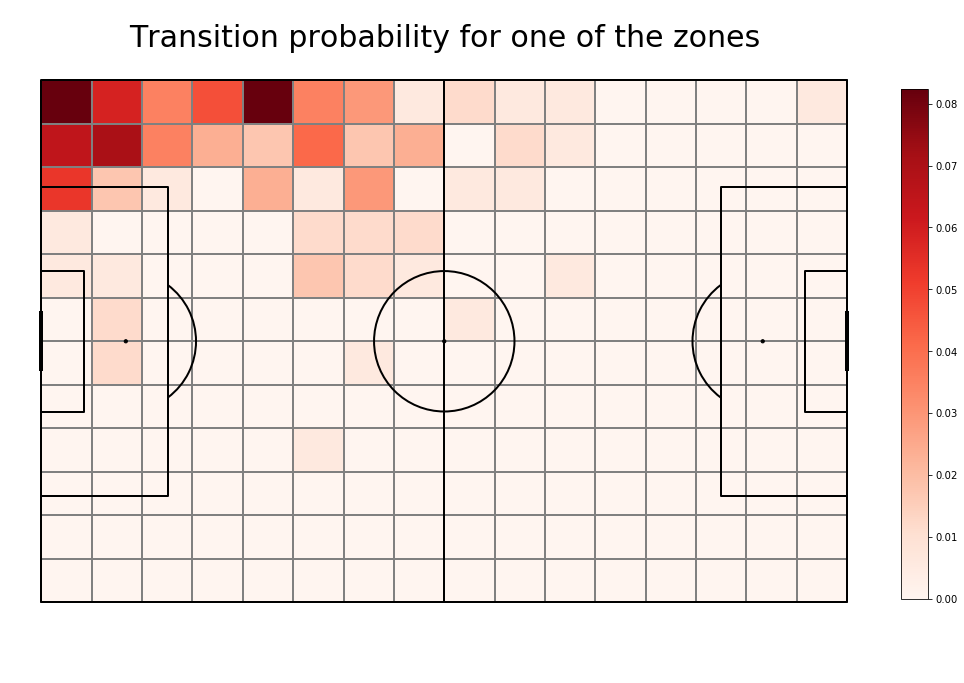

In [15]:
#let's plot it for the zone [1,1] - left down corner
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)

#Change the index here to change the zone.
goal["statistic"] = transition_matrices[0]
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])

#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Transition probability for one of the zones', fontsize = 30)
plt.show()

In [16]:
move_df.head(3)

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,nextEvent,kickedOut,x,y,end_x,end_y,start_sector,end_sector
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,High pass,0,51.45,34.68,32.55,14.96,"(8, 7)","(5, 3)"
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172,Head pass,0,32.55,14.96,53.55,17.00,"(5, 3)","(9, 4)"
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173,Head pass,0,53.55,17.00,36.75,19.72,"(9, 4)","(6, 4)"


In [17]:
df_count_starts.head(3)

,start_sector,count_starts
0,"(1, 1)",170
1,"(1, 2)",224
2,"(1, 3)",134


In [18]:
df_count_starts.iloc[0]

start_sector    (1, 1)
count_starts       170
Name: 0, dtype: object

In [19]:
transition_matrices[0]

array([[0.08235294, 0.05882353, 0.03529412, 0.04705882, 0.08235294,
        0.03529412, 0.02941176, 0.00588235, 0.01176471, 0.00588235,
        0.00588235, 0.        , 0.        , 0.        , 0.        ,
        0.00588235],
       [0.06470588, 0.07058824, 0.03529412, 0.02352941, 0.01764706,
        0.04117647, 0.01764706, 0.02352941, 0.        , 0.01176471,
        0.00588235, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.05294118, 0.01764706, 0.00588235, 0.        , 0.02352941,
        0.00588235, 0.02941176, 0.        , 0.00588235, 0.00588235,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.00588235, 0.        , 0.        , 0.        , 0.        ,
        0.01176471, 0.01176471, 0.01176471, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.00588235, 0.00588235, 0.        , 0.        , 0.        ,
        0.01764706, 0.01176471, 

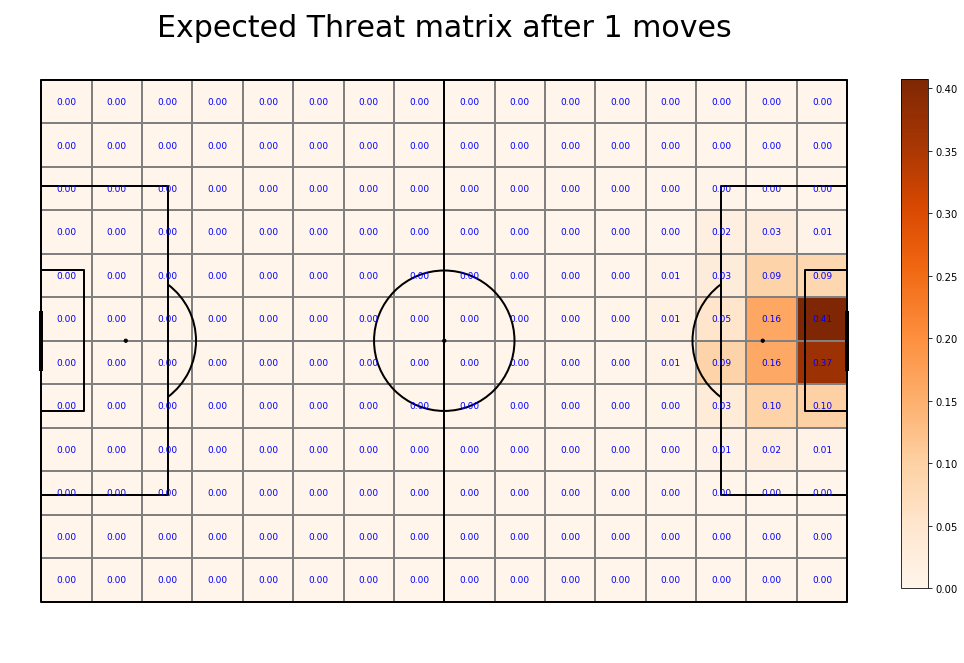

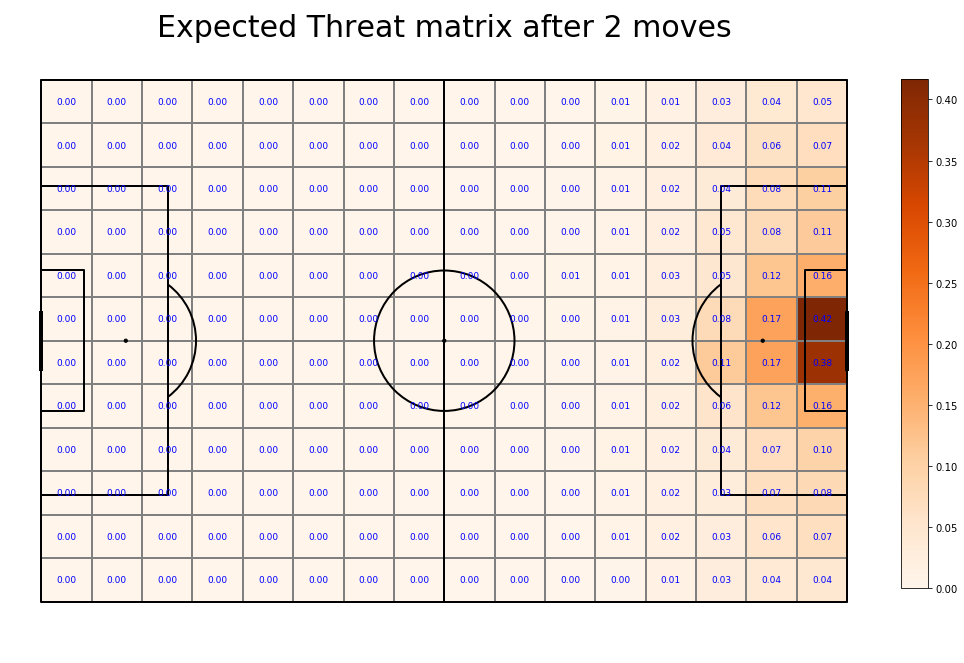

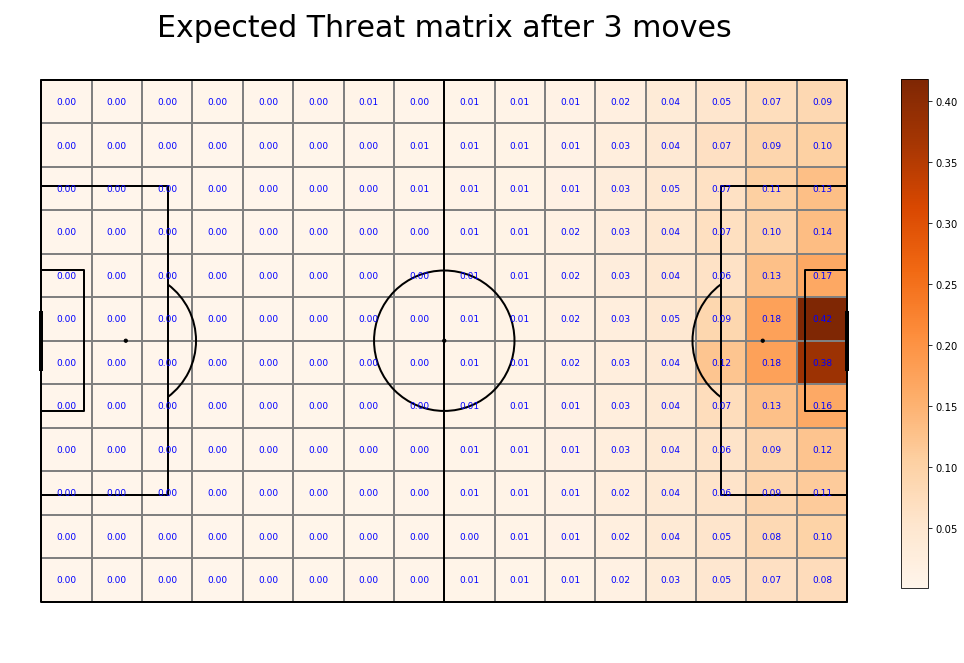

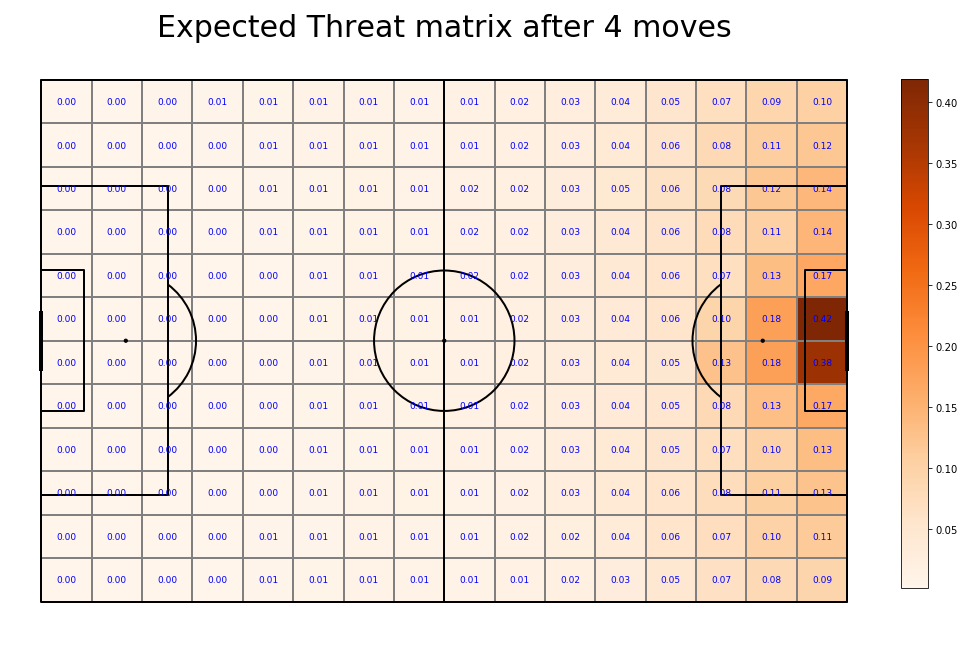

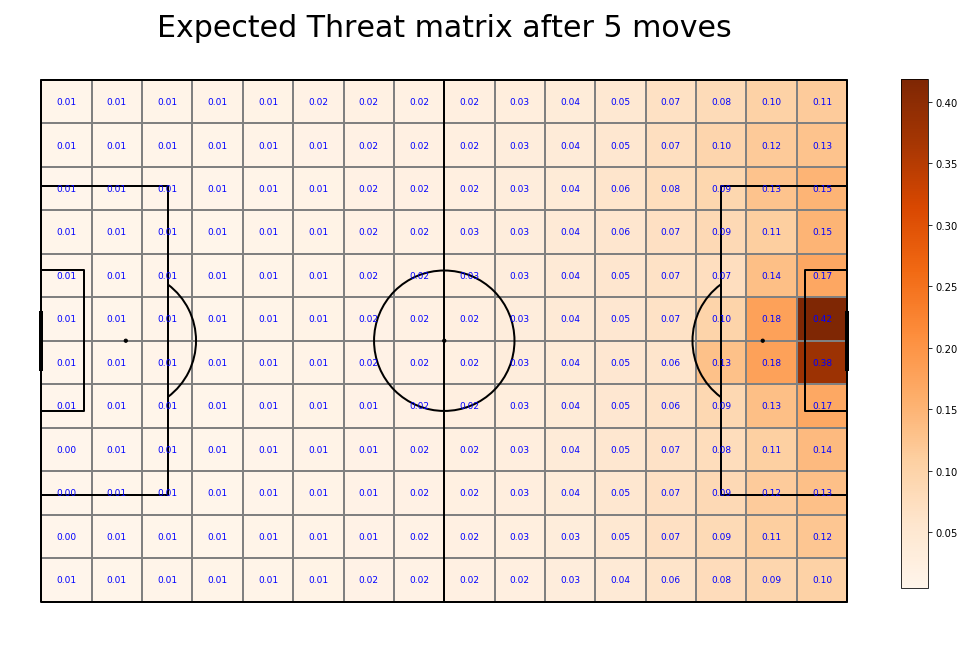

In [20]:
transition_matrices_array = np.array(transition_matrices)
xT = np.zeros((12, 16))

for i in range(5):
    shoot_expected_payoff = goal_probability*shot_probability
    move_expected_payoff = move_probability*(np.sum(np.sum(transition_matrices_array*xT, axis = 2), axis = 1).reshape(16,12).T)
    xT = shoot_expected_payoff + move_expected_payoff

    #let's plot it!
    fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.01, title_space=0, endnote_space=0)
    
    goal["statistic"] = xT
    pcm  = pitch.heatmap(goal, cmap='Oranges', edgecolor='grey', ax=ax['pitch'])
    labels = pitch.label_heatmap(goal, color='blue', fontsize=9,
                             ax=ax['pitch'], ha='center', va='center', str_format="{0:,.2f}", zorder = 3)
    #legend to our plot
    ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
    cbar = plt.colorbar(pcm, cax=ax_cbar)
    txt = 'Expected Threat matrix after ' +  str(i+1) + ' moves'
    fig.suptitle(txt, fontsize = 30)
    plt.show()

In [21]:
#only successful
successful_moves = move_df.loc[move_df.apply(lambda x:{'id':1801} in x.tags, axis = 1)]

#calculatexT
successful_moves["xT_added"] = successful_moves.apply(lambda row: xT[row.end_sector[1] - 1][row.end_sector[0] - 1] 
                                                      - xT[row.start_sector[1] - 1][row.start_sector[0] - 1], axis = 1)

#only progressive
value_adding_actions = successful_moves.loc[successful_moves["xT_added"] > 0]

In [22]:
# Don’t remove unsuccessful and non-progressive actions. Assign -xT for unsuccessful ones!

#calculatexT
move_df["xT_added"] = move_df.apply(lambda row: xT[row.end_sector[1] - 1][row.end_sector[0] - 1] 
                                                      - xT[row.start_sector[1] - 1][row.start_sector[0] - 1], axis = 1)

move_df.head(3)

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,...,id,nextEvent,kickedOut,x,y,end_x,end_y,start_sector,end_sector,xT_added
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,...,177959171,High pass,0,51.45,34.68,32.55,14.96,"(8, 7)","(5, 3)",-0.007956
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,...,177959172,Head pass,0,32.55,14.96,53.55,17.00,"(5, 3)","(9, 4)",0.014927
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,...,177959173,Head pass,0,53.55,17.00,36.75,19.72,"(9, 4)","(6, 4)",-0.011937


In [23]:
#group by player
xT_by_player = move_df.groupby(["playerId"])["xT_added"].sum().reset_index()

#merging player name
path = os.path.join(str(pathlib.Path().resolve().parents[0]), "data", 'Wyscout', 'players.json')
player_df = pd.read_json(path, encoding='unicode-escape')
player_df.rename(columns = {'wyId':'playerId'}, inplace=True)
player_df["role"] = player_df.apply(lambda x: x.role["name"], axis = 1)
to_merge = player_df[['playerId', 'shortName', 'role']]
summary = xT_by_player.merge(to_merge, how = "left", on = ["playerId"])

#filtering over 400 per game
path = os.path.join(str(pathlib.Path().resolve().parents[0]), "data", "Wyscout", "minutes_played", 'minutes_played_per_game_England.json')
minutes_per_game = pd.read_json(path, encoding='unicode-escape')
# with open(path) as f:
#     minutes_per_game = json.load(f)
# minutes_per_game = pd.DataFrame(minutes_per_game)
minutes = minutes_per_game.groupby(["playerId"]).minutesPlayed.sum().reset_index()
summary = minutes.merge(summary, how = "left", on = ["playerId"])
summary = summary.fillna(0)
summary = summary.loc[summary["minutesPlayed"] > 400]

#calculating per 90
summary["xT_per_90"] = summary["xT_added"]*90/summary["minutesPlayed"]

In [24]:
player_df.head(3)

,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,playerId,foot,shortName,currentNationalTeamId
0,"{'name': 'Turkey', 'id': '792', 'alpha3code': ...",78,Harun,,Tekin,4502,1989-06-17,187,Goalkeeper,"{'name': 'Turkey', 'id': '792', 'alpha3code': ...",32777,right,H. Tekin,4687
1,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",73,Malang,,Sarr,3775,1999-01-23,182,Defender,"{'name': 'France', 'id': '250', 'alpha3code': ...",393228,left,M. Sarr,4423
2,"{'name': 'France', 'id': '250', 'alpha3code': ...",72,Over,,Mandanda,3772,1998-10-26,176,Goalkeeper,"{'name': 'France', 'id': '250', 'alpha3code': ...",393230,,O. Mandanda,null


In [25]:
minutes_per_game.head(3)

,playerId,shortName,matchId,teamId,teamName,player_in_min,player_out_min,minutesPlayed,red_card
0,9206,C. Wood,2500089,1646,Burnley FC,0,61,61,0
1,9127,S. Vokes,2500089,1646,Burnley FC,61,95,34,0
2,93,J. Guðmunds­son,2500089,1646,Burnley FC,0,80,80,0


In [26]:
possession_dict = {}

#for every row in the dataframe
for i, row in minutes_per_game.iterrows():
    #take player id, team id and match id, minute in and minute out
    player_id, team_id, match_id = row["playerId"], row["teamId"], row["matchId"]
    
    #create a key in dictionary if player encounterd first time
    if not str(player_id) in possession_dict.keys():
        possession_dict[str(player_id)] = {'team_passes': 0, 'all_passes' : 0}
    min_in = row["player_in_min"]*60
    min_out = row["player_out_min"]*60

    #get the dataframe of events from the game
    match_df = df.loc[df["matchId"] == match_id].copy()
    #add to 2H the highest value of 1H
    match_df.loc[match_df["matchPeriod"]=="2H", 'eventSec'] = (match_df.loc[match_df["matchPeriod"]=="2H", 'eventSec'] 
                                                                + match_df.loc[match_df["matchPeriod"] == "1H"]["eventSec"].iloc[-1])
    #take all events from this game and this period
    player_in_match_df = match_df.loc[match_df["eventSec"] > min_in].loc[match_df["eventSec"] <= min_out]
    #take all passes and won duels as described
    all_passes = player_in_match_df.loc[player_in_match_df["eventName"].isin(["Pass", "Duel"])]
    
    #adjusting for no passes in this period (Tuanzebe)
    if len(all_passes) > 0:
        #removing lost air duels
        no_contact = all_passes.loc[all_passes["subEventName"]\
                                    .isin(["Air duel", "Ground defending duel","Ground loose ball duel"])]\
                                        .loc[all_passes.apply(lambda x:{'id':701} in x.tags, axis = 1)]
        all_passes = all_passes.drop(no_contact.index)
    
    #take team passes
    team_passes = all_passes.loc[all_passes["teamId"] == team_id]
    #append it {player id: {team passes: sum, all passes : sum}}
    possession_dict[str(player_id)]["team_passes"] += len(team_passes)
    possession_dict[str(player_id)]["all_passes"] += len(all_passes)

#calculate possession for each player
percentage_dict = {key: value["team_passes"]/value["all_passes"] if value["all_passes"] > 0 else 0 for key, value in possession_dict.items()}

#create a dataframe
percentage_df = pd.DataFrame(percentage_dict.items(), columns = ["playerId", "possession"])
percentage_df["playerId"] = percentage_df["playerId"].astype(int)

In [27]:
percentage_df.head(3)

,playerId,possession
0,9206,0.446999
1,9127,0.439018
2,93,0.438288


In [28]:
# save the percentage_df containing player possessions for future use
percentage_df.to_json('../data/Wyscout/minutes_played/player_possession_England.json')

In [29]:
#adjusting for possession
# path = os.path.join(str(pathlib.Path().resolve().parents[0]), "data", "Wyscout", "minutes_played", 'player_possession_England.json')
# with open(path) as f:
#     percentage_df = json.load(f)
# percentage_df = pd.DataFrame(percentage_df)

#merge it
summary = summary.merge(percentage_df, how = "left", on = ["playerId"])
summary["xT_adjusted_per_90"] = (summary["xT_added"]/summary["possession"])*90/summary["minutesPlayed"]
summary[['shortName', 'xT_adjusted_per_90']].sort_values(by='xT_adjusted_per_90', ascending=False).head(5)

,shortName,xT_adjusted_per_90
76,C. Adam,2.209210
27,Fàbregas,2.016491
78,J. Shelvey,1.860925
39,Philippe Coutinho,1.754680
125,C. Brunt,1.678143
